## EDA & Cleaning: Exploring categorical features

Using the Titanic dataset from [this](https://www.kaggle.com/c/titanic/overview) Kaggle competition.

This dataset contains information about 891 people who were on board the ship when departed on April 15th, 1912. As noted in the description on Kaggle's website, some people aboard the ship were more likely to survive the wreck than others. There were not enough lifeboats for everybody so women, children, and the upper-class were prioritized. Using the information about these 891 passengers, the challenge is to build a model to predict which people would survive based on the following fields:

- **Name** (str) - Name of the passenger
- **Pclass** (int) - Ticket class
- **Sex** (str) - Sex of the passenger
- **Age** (float) - Age in years
- **SibSp** (int) - Number of siblings and spouses aboard
- **Parch** (int) - Number of parents and children aboard
- **Ticket** (str) - Ticket number
- **Fare** (float) - Passenger fare
- **Cabin** (str) - Cabin number
- **Embarked** (str) - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

**This section focuses on exploring the `Sex`, `Cabin`, and `Embarked` features.**

### Read in data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

titanic = pd.read_csv('../../../titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Drop all continuous features
cont_feat = ['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Fare']
titanic.drop(cont_feat, axis=1, inplace=True)
titanic.head()

,Survived,Sex,Ticket,Cabin,Embarked
0,0,male,A/5 21171,NaN,S
1,1,female,PC 17599,C85,C
2,1,female,STON/O2. 3101282,NaN,S
3,1,female,113803,C123,S
4,0,male,373450,NaN,S


### Explore categorical features

Explore `Sex`, `Cabin`, and `Embarked`.

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  891 non-null    int64 
 1   Sex       891 non-null    object
 2   Ticket    891 non-null    object
 3   Cabin     204 non-null    object
 4   Embarked  889 non-null    object
dtypes: int64(1), object(4)
memory usage: 34.9+ KB


We can see that we have a lot of mising values in the `Cabin` feature. Also there are a few missing values in the `Embarked` feature. We will start by exploring the `Cabin` feature first

In [4]:
# Use groupby to compare to the target feature to find out if there 
#    is a reason for the missing values
titanic.groupby(titanic['Cabin'].isnull()).mean()

,Survived
Cabin,
False,0.666667
True,0.299854


This is showing us that there is a really dramtic split. There is over 66% of the people who have non-missing `Cabin` values that survived. While just under 30% of those who had a missing value survived. In this case, it is very clear that `Cabin` is not missing at random, it's actually a very strong indicator whether somebody survived or not.

This really illustrates the value of exploring your data. Typically if you see a field that has a missing value for 687 / 891, you'll usually just drop that entire column because it's not really offering a whole lot of value when almost 80% of your examples have a missing value for that field. However, our exploration uncovered a tremendous source of value for the model.

One easy hypothsis here is that people without an assigned cabin literlly don't have a cabin. Maybe they were stuck somewhere in the bows of the ship and that's why so few survived. Ultimately, the reason does not really matter so much as our treatment of this feature. So the way we will handle this it to just create a binanry indicator that just says whether the person had a cabin or not.

In [5]:
# Create a new feature using the where method
# The where method is just like an if/else statement
#    np.where(<condition>, <if true>, <else>)
titanic['Cabin_ind'] = np.where(titanic['Cabin'].isnull(), 0, 1)
titanic.head(10)

,Survived,Sex,Ticket,Cabin,Embarked,Cabin_ind
0,0,male,A/5 21171,NaN,S,0
1,1,female,PC 17599,C85,C,1
2,1,female,STON/O2. 3101282,NaN,S,0
3,1,female,113803,C123,S,1
4,0,male,373450,NaN,S,0
5,0,male,330877,NaN,Q,0
6,0,male,17463,E46,S,1
7,0,male,349909,NaN,S,0
8,1,female,347742,NaN,S,0
9,1,female,237736,NaN,C,0


### Plot categorical features

<Figure size 432x288 with 0 Axes>

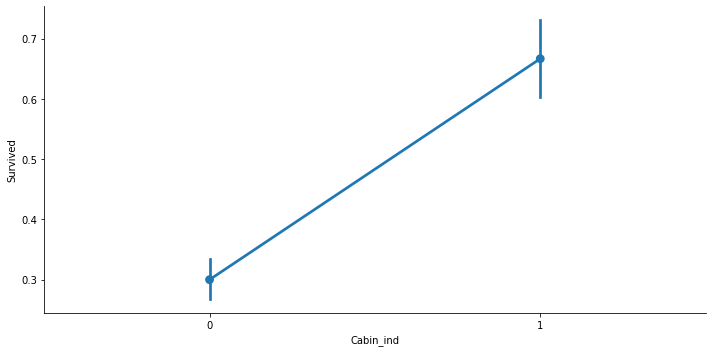

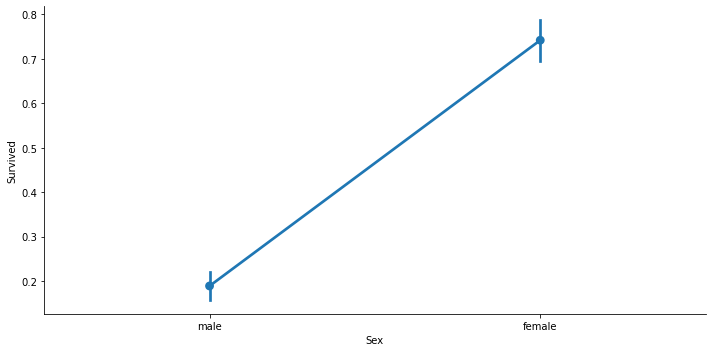

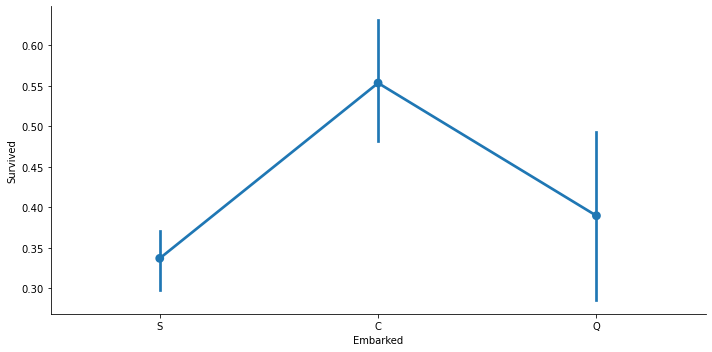

In [6]:
for i, col in enumerate(['Cabin_ind', 'Sex', 'Embarked']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2);

In [7]:
# We will use pivot tables to explore if the Embarked feature is going 
#    to added any value that we are not already getting from other features
titanic.pivot_table('Survived', index='Sex', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


In [8]:
titanic.pivot_table('Survived', index='Cabin_ind', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Cabin_ind,,,
0,99,73,515
1,69,4,129


Here we have learned that `Sex` and `Cabin_ind` have a very strong correlation with survival, and they could be really useful features in a model. We also learned that `Embarked` is not providing much information, that isn't already covered by our other features in the model. Thus, it's repetitive and not really useful to the model.